## 2 Cont'd: Obtaining the DNA physical properties of each sequence
GB Shape: http://rohsdb.cmb.usc.edu/
"Predicted structural properties for every human genome positions are available here"

### 2-2: Identification of negative examples

In [2]:
from Bio import SeqIO
from random import sample
import pandas as pd
import numpy as np
import math
import time
import matplotlib.pyplot as plt
from collections import Counter

### Obtaining the Position Weight Matrix (PWM) of the TF

In [3]:
tf = 'TBP'

# Note: factorbookMotifPwm.txt contains PWM of all TFs that was listed in Part 1

# Obtain PWM of the TF of interest
with open('factorbookMotifPwm.txt') as f:
    for line in f:
        if tf in line:  # If the line is for the TF
            line = line.split(",")
            for i in range(len(line)):
                if i == 0:
                    tf_name = line[i].split("\t")[0]
                    tf_len = line[i].split("\t")[1]
                    tf_len = int(tf_len)
                    print("tf_name:", tf_name)
                    print("tf_len:", tf_len)
                    line[i] = line[i].split("\t")[-1]
                else:
                    line[i] = line[i].replace("\t", "")
            del line[-1]
            print(tf_name)
            print(len(line))
            line_int = [float(i) for i in line]
            # Convert to a numpy array
            pwm_arr = np.array(line_int)
            pwm_arr.astype(int)
            pwm_arr2 = np.reshape(pwm_arr, (4, tf_len))
            print(pwm_arr2)
            print(np.sum(pwm_arr2, axis=0))  # Validating that the PWM makes sense (columns add up to 1)

tf_name: TBP
tf_len: 20
TBP
80
[[0.088608 0.189873 0.202532 0.139241 0.139241 0.189873 0.196203 0.113924
  0.082278 0.14557  0.044304 0.037975 0.126582 0.012658 0.316456 0.031646
  0.955696 0.056962 0.898734 0.170886]
 [0.563291 0.43038  0.316456 0.405063 0.35443  0.512658 0.411392 0.322785
  0.5      0.329114 0.417722 0.689873 0.170886 0.088608 0.       0.
  0.018987 0.006329 0.031646 0.234177]
 [0.227848 0.259494 0.360759 0.386076 0.424051 0.21519  0.246835 0.417722
  0.278481 0.35443  0.443038 0.050633 0.       0.       0.       0.
  0.       0.       0.050633 0.525316]
 [0.120253 0.120253 0.120253 0.06962  0.082278 0.082278 0.14557  0.14557
  0.139241 0.170886 0.094937 0.221519 0.702532 0.898734 0.683544 0.968354
  0.025316 0.936709 0.018987 0.06962 ]]
[1.       1.       1.       1.       1.       0.999999 1.       1.000001
 1.       1.       1.000001 1.       1.       1.       1.       1.
 0.999999 1.       1.       0.999999]


#### Determination of threshold for sequence similarity
* Already have: the actual sequences of positive examples
* From: these sequences (fasta file containing them)
* Calculate the average log probability of all the positive examples
* Use this average log probability as the threshold when identifying the unbound sites

In [5]:
# Create an ordered list of chromosomes
list_chrs = ['chr%s' % s for s in range(1,23)]
list_chrs.append("chrX")
print(list_chrs)
print(len(list_chrs))

['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6', 'chr7', 'chr8', 'chr9', 'chr10', 'chr11', 'chr12', 'chr13', 'chr14', 'chr15', 'chr16', 'chr17', 'chr18', 'chr19', 'chr20', 'chr21', 'chr22', 'chrX']
23


In [7]:
"""
Find the log probability threshold for bound sequence

Idea: The sequences that are bound must have certain pattern (if the sequence where TF can potentially bind is 
too different from what's suggested by PWM, indicated by low log probability, then TF won't bind to the sequence.
=> negative example)

Log probability is used to avoid numerical underflow
"""

max_logprob_all = 0
for chom in list_chrs:
    print("chom: ", chom)
    filename = "./ExtractedSeqs_" + tf + "/seqs_" + tf + "_fwd_pos/seqs_" + chom + "_" + tf + "_fwd_pos.fasta"
    sum_logprob = 0
    avg_logprob = 0
    max_logprob = 0

    n_seqs = len([len(rec) for rec in SeqIO.parse(filename, "fasta")])
    print("# of seqs: ", n_seqs)

    with open(filename, "r") as fh:
        count = 0
        for seq_record in SeqIO.parse(fh, "fasta"):
            sequence = seq_record.seq
            target_seq = sequence
            k = 0
            log_prob = 0
            if target_seq[k+2] != "T" and target_seq[k+2] != "t" and target_seq[k+3] != "G" and target_seq[k+3] != "g" and target_seq[k+4] != "T" and target_seq[k+4] != "t" and target_seq[k+9] != "C" and target_seq[k+9] != "c" and target_seq[k+9] != "A" and target_seq[k+9] != "a":
                #print("Success")
                count += 1
                for i in range(20):
                    if target_seq[i] == 'A' or target_seq[i] == 'a':
                        arr_idx = 0
                    elif target_seq[i] == 'C' or target_seq[i] == 'c':
                        arr_idx = 1
                    elif target_seq[i] == 'G' or target_seq[i] == 'g':
                        arr_idx = 2
                    elif target_seq[i] == 'T' or target_seq[i] == 't':
                        arr_idx = 3
                    else: # if "N"
                        break
                    log_prob += math.log(pwm_arr2[arr_idx, i])
                sum_logprob += log_prob
                if max_logprob > log_prob:
                    max_logprob = log_prob

        avg_logprob = sum_logprob / n_seqs
        print("count: ", count)
        print("avg_logprob: ", avg_logprob)
        print("max_logprob: ", max_logprob)        
        print("=============")
    if max_logprob_all > max_logprob:
        max_logprob_all = max_logprob
    print("max_logprob_all: ", max_logprob_all)
    logp_thresh = math.floor(max_logprob_all)

chom:  chr1
# of seqs:  29
count:  29
avg_logprob:  -18.860297409367234
max_logprob:  -21.0973227165288
chom:  chr2
# of seqs:  26
count:  26
avg_logprob:  -19.345488155677227
max_logprob:  -21.397387053610977
chom:  chr3
# of seqs:  20
count:  20
avg_logprob:  -19.40050314208107
max_logprob:  -21.165886642931063
chom:  chr4
# of seqs:  14
count:  14
avg_logprob:  -19.403915050405836
max_logprob:  -21.14473226712874
chom:  chr5
# of seqs:  15
count:  15
avg_logprob:  -19.775589817586106
max_logprob:  -21.195684381362636
chom:  chr6
# of seqs:  50
count:  50
avg_logprob:  -18.82942004757112
max_logprob:  -21.299439012992305
chom:  chr7
# of seqs:  15
count:  15
avg_logprob:  -18.85284669388053
max_logprob:  -21.708643588226888
chom:  chr8
# of seqs:  21
count:  21
avg_logprob:  -19.345781317015977
max_logprob:  -21.510405118121515
chom:  chr9
# of seqs:  9
count:  9
avg_logprob:  -18.530627366103133
max_logprob:  -20.905995310208187
chom:  chr10
# of seqs:  16
count:  16
avg_logprob:  -

##### Determination of threshold: Result
* Based on the above code, it was observed that the maximum log probability was almost for all in the -21s (some in the -20s). Therefore, the student decided to set the threshold as -22.

#### Identification of negative sequences

In [14]:
filename = "./ExtractedSeqs/seqs_TBP_fwd_neg/seqs_chr1_TBP_fwd_neg.fasta"
n_seqs = len([len(rec) for rec in SeqIO.parse(filename, "fasta")])
print("# of sequences contained in the fasta:", n_seqs)

# of sequences contained in the fasta: 324


To save computational time, I will make the unbound sequence under the assumption that each region in the bedfile contains one binding site for TBP

In [33]:
s_time = time.time()
fileout = "./ExtractedSeqs_" + tf + "/seqs_" + tf + "_fwd_neg/unbound/seqs_" + tf + "_fwd_neg_unbound.fasta"
for chom in list_chrs:
    print("chom: ", chom)
    filename = "./ExtractedSeqs_" + tf + "/seqs_" + tf + "_fwd_neg/seqs_" + chom + "_" + tf + "_fwd_neg.fasta"
    #logp_thresh = -22
    
    with open(filename, "r") as fh:
        with open(fileout, "a") as fout:
            for seq_record in SeqIO.parse(fh, "fasta"):
                sequence = seq_record.seq
                #print(sequence)
                start_time = time.time()
                #print("length of the seq:", len(sequence))
                count2 = 0
                for j in range(len(sequence)-20):
                    count += 1
                    target_seq = sequence[j:j+20]
                    if "N" in target_seq:
                        N_in = "YesN"
                    else:
                        N_in = "NoN"
                    if N_in == "NoN":
                        #if target_seq[k+12] != "G" and target_seq[k+12] != "g" and target_seq[k+13] != "G" and target_seq[k+13] != "g" and target_seq[k+14] != "G" and target_seq[k+14] != "g" and target_seq[k+14] != "C" and target_seq[k+14] != "c" and target_seq[k+15] != "G" and target_seq[k+15] != "g" and target_seq[k+15] != "C" and target_seq[k+15] != "c" and target_seq[k+16] != "G" and target_seq[k+16] != "g" and target_seq[k+17] != "G" and target_seq[k+17] != "g":
                        if target_seq[k+2] != "T" and target_seq[k+2] != "t" and target_seq[k+3] != "G" and target_seq[k+3] != "g" and target_seq[k+4] != "T" and target_seq[k+4] != "t" and target_seq[k+9] != "C" and target_seq[k+9] != "c" and target_seq[k+9] != "A" and target_seq[k+9] != "a":
                            log_prob = 0
                            for i in range(20):
                                if target_seq[i] == 'A' or target_seq[i] == 'a':
                                    arr_idx = 0
                                elif target_seq[i] == 'C' or target_seq[i] == 'c':
                                    arr_idx = 1
                                elif target_seq[i] == 'G' or target_seq[i] == 'g':
                                    arr_idx = 2
                                elif target_seq[i] == 'T' or target_seq[i] == 't':
                                    arr_idx = 3
                                else: # if "N"
                                    break

                                log_prob += math.log(pwm_arr2[arr_idx, i])
                            if log_prob > logp_thresh: # if sum_logprob > -22
                                fout.write(str(target_seq)+"\n")

                end_time = time.time()
                time_taken = end_time - start_time
e_time = time.time()
r_time = e_time - s_time
print("Running time of grid search to identify negative examples:", r_time)

chom:  chr1
chom:  chr2
chom:  chr3
chom:  chr4
chom:  chr5
chom:  chr6
chom:  chr7
chom:  chr8
chom:  chr9
chom:  chr10
chom:  chr11
chom:  chr12
chom:  chr13
chom:  chr14
chom:  chr15
chom:  chr16
chom:  chr17
chom:  chr18
chom:  chr19
chom:  chr20
chom:  chr21
chom:  chr22
chom:  chrX
Running time of grid search: 57.46489882469177


In [15]:
filename = "./ExtractedSeqs/seqs_TBP_fwd_neg/seqs_chr1_TBP_fwd_neg.fasta"
n_seqs = len([len(rec) for rec in SeqIO.parse(filename, "fasta")])
print("# of sequences contained in the fasta:", n_seqs)
fileout = "seqs_chr1_TBP_fwd_neg_unbound.fasta"
logp_thresh = -22  # threshold of the log probability

with open(filename, "r") as fh:
    with open(fileout, "w") as fout:
        records = list(SeqIO.parse(fh, "fasta"))
        sample_seq = records[0].seq  # first record
        print(sample_seq)

# of sequences contained in the fasta: 324
TTCTTGGATGTTCGGGAAAGGGGGTTATTATCTAGGATCCTTGAAGCACCCCCAAGGGCATCTTCTCAAAGTTGGATGTGTGCATTTTCCTGAGAGGAAAGCTTTCCCACATTATACAGCTTCTGAAAGGGTTGCTTGACCCACAGATGTGAAGCTGAGGCTGAAGGAGACTGATGTGGTTTCTCCTCAGTTTCTCTGTGCAGCACCAGGTGGCAGCAGAGGTCAGCAAGGCAAACCCGAGCCCGGGGATGCGGAGTGGGGGCAGCTACGTCCTCTCTTGAGCTACAGCAGATTCACTCTGTTCTGTTTCATTGTTGTTTAGTTTGCGTTGTGTTTCTCCAACTTTGTGCCTCATCAGGAAAAGCTTTGGATCACAATTCCCAGtgctgaagaaaaggccaaactctggaaaaaattttgaatattttgagccaaatgt


### 2-2: Obtaining DNA physical properties

- Used DNAshape (https://rohslab.usc.edu/DNAshape/), a high-throughput method for predicting structural properties of human genome positions, to obtain the DNA physical properties of positive and negative examples
- Once DNAshape had finished running, the data on the physical properties - minor groove width (MGW), Roll, helical twist (HelT), and propeller twist (ProT)  - were downloaded. For every run, the tool outputted a a graph like below for each of the four physical properties
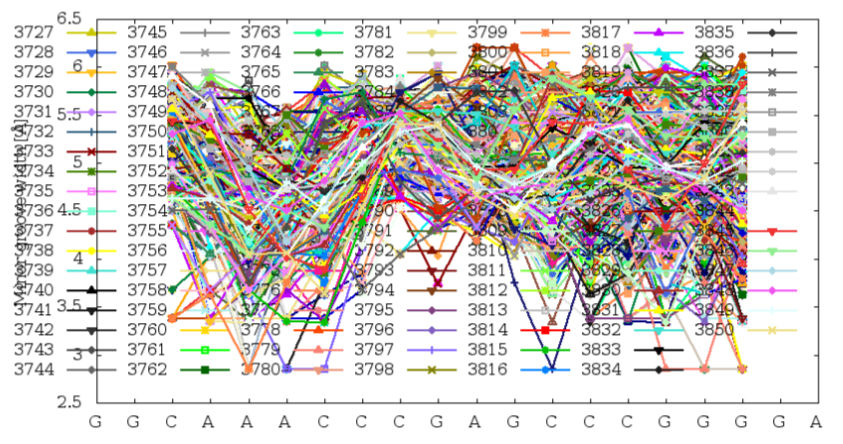

### 2-3: Creating dataframes containing physical properties (to be used in machine learning)

In [12]:
bad_words = ['>']
list_DNAprops = ["MGW", "HelT", "Roll", "ProT"]
print(list_DNAprops)

['MGW', 'HelT', 'Roll', 'ProT']


In [13]:
# Create textfiles that will later be converted to pandas dataframe
for prop in list_DNAprops:
    filein = "./ExtractedSeqs_TBP/phpnRRPIR/phpnRRPIR." + prop + ".txt"
    fileout = "./ExtractedSeqs_TBP/phpnRRPIR/phpnRRPIR_processed." + prop + ".txt"

    with open(filein) as oldfile, open(fileout, 'w') as newfile:
        n = 20
        list_header = [prop] * n
        #print(list_header)
        for j in range(n):
            list_header[j] = list_header[j] + str(j+1)
        header = ','.join(list_header)
        print(header)
        newfile.write(header)
        newfile.write("\n")
        for line in oldfile:
            if not any(bad_word in line for bad_word in bad_words):
                newfile.write(line)

MGW1,MGW2,MGW3,MGW4,MGW5,MGW6,MGW7,MGW8,MGW9,MGW10,MGW11,MGW12,MGW13,MGW14,MGW15,MGW16,MGW17,MGW18,MGW19,MGW20
HelT1,HelT2,HelT3,HelT4,HelT5,HelT6,HelT7,HelT8,HelT9,HelT10,HelT11,HelT12,HelT13,HelT14,HelT15,HelT16,HelT17,HelT18,HelT19,HelT20
Roll1,Roll2,Roll3,Roll4,Roll5,Roll6,Roll7,Roll8,Roll9,Roll10,Roll11,Roll12,Roll13,Roll14,Roll15,Roll16,Roll17,Roll18,Roll19,Roll20
ProT1,ProT2,ProT3,ProT4,ProT5,ProT6,ProT7,ProT8,ProT9,ProT10,ProT11,ProT12,ProT13,ProT14,ProT15,ProT16,ProT17,ProT18,ProT19,ProT20


In [14]:
files_unbound = ["./ExtractedSeqs_TBP/phpnRRPIR/phpnRRPIR_processed." + prop + ".txt" for prop in list_DNAprops]
print(files_unbound)

['./ExtractedSeqs_TBP/phpnRRPIR/phpnRRPIR_processed.MGW.txt', './ExtractedSeqs_TBP/phpnRRPIR/phpnRRPIR_processed.HelT.txt', './ExtractedSeqs_TBP/phpnRRPIR/phpnRRPIR_processed.Roll.txt', './ExtractedSeqs_TBP/phpnRRPIR/phpnRRPIR_processed.ProT.txt']


In [15]:
for i in range(len(files_unbound)):
    if i == 0:
        print(files_unbound[i])
        df_properties_ub = pd.read_csv(files_unbound[i])
    
    else:
        print(files_unbound[i])
        df_property_ub = pd.read_csv(files_unbound[i])
        df_properties_ub = pd.concat([df_properties_ub, df_property_ub.reindex(df_properties_ub.index)], axis=1)

print(df_properties_ub.shape)
df_properties_ub["label"] = "unbound"
print(df_properties_ub.shape)

./ExtractedSeqs_TBP/phpnRRPIR/phpnRRPIR_processed.MGW.txt
./ExtractedSeqs_TBP/phpnRRPIR/phpnRRPIR_processed.HelT.txt
./ExtractedSeqs_TBP/phpnRRPIR/phpnRRPIR_processed.Roll.txt
./ExtractedSeqs_TBP/phpnRRPIR/phpnRRPIR_processed.ProT.txt
(1204, 80)
(1204, 81)


##### Repeat the procedure for bound sequences (positive examples)

In [16]:
# Create textfiles that will later be converted to pandas dataframe
for prop in list_DNAprops:
    filein = "./ExtractedSeqs_TBP/phpYwJDXp_pos/phpYwJDXp." + prop + ".txt"
    fileout = "./ExtractedSeqs_TBP/phpYwJDXp_pos/phpYwJDXp_processed." + prop + ".txt"

    with open(filein) as oldfile, open(fileout, 'w') as newfile:
        n = 20
        list_header = [prop] * n
        #print(list_header)
        for j in range(n):
            list_header[j] = list_header[j] + str(j+1)
        header = ','.join(list_header)
        print(header)
        newfile.write(header)
        newfile.write("\n")
        for line in oldfile:
            if not any(bad_word in line for bad_word in bad_words):
                newfile.write(line)

MGW1,MGW2,MGW3,MGW4,MGW5,MGW6,MGW7,MGW8,MGW9,MGW10,MGW11,MGW12,MGW13,MGW14,MGW15,MGW16,MGW17,MGW18,MGW19,MGW20
HelT1,HelT2,HelT3,HelT4,HelT5,HelT6,HelT7,HelT8,HelT9,HelT10,HelT11,HelT12,HelT13,HelT14,HelT15,HelT16,HelT17,HelT18,HelT19,HelT20
Roll1,Roll2,Roll3,Roll4,Roll5,Roll6,Roll7,Roll8,Roll9,Roll10,Roll11,Roll12,Roll13,Roll14,Roll15,Roll16,Roll17,Roll18,Roll19,Roll20
ProT1,ProT2,ProT3,ProT4,ProT5,ProT6,ProT7,ProT8,ProT9,ProT10,ProT11,ProT12,ProT13,ProT14,ProT15,ProT16,ProT17,ProT18,ProT19,ProT20


In [18]:
files_bound = ["./ExtractedSeqs_TBP/phpYwJDXp_pos/phpYwJDXp_processed." + prop + ".txt" for prop in list_DNAprops]
print(files_bound)

['./ExtractedSeqs_TBP/phpYwJDXp_pos/phpYwJDXp_processed.MGW.txt', './ExtractedSeqs_TBP/phpYwJDXp_pos/phpYwJDXp_processed.HelT.txt', './ExtractedSeqs_TBP/phpYwJDXp_pos/phpYwJDXp_processed.Roll.txt', './ExtractedSeqs_TBP/phpYwJDXp_pos/phpYwJDXp_processed.ProT.txt']


In [19]:
for i in range(len(files_bound)):
    if i == 0:
        print(files_bound[i])
        df_properties_b = pd.read_csv(files_bound[i])    
    else:
        print(files_bound[i])
        df_property_b = pd.read_csv(files_bound[i])
        df_properties_b = pd.concat([df_properties_b, df_property_b.reindex(df_properties_b.index)], axis=1)

print(df_properties_b.shape)
df_properties_b["label"] = "bound"
print(df_properties_b.shape)

./ExtractedSeqs_TBP/phpYwJDXp_pos/phpYwJDXp_processed.MGW.txt
./ExtractedSeqs_TBP/phpYwJDXp_pos/phpYwJDXp_processed.HelT.txt
./ExtractedSeqs_TBP/phpYwJDXp_pos/phpYwJDXp_processed.Roll.txt
./ExtractedSeqs_TBP/phpYwJDXp_pos/phpYwJDXp_processed.ProT.txt
(392, 80)
(392, 81)


##### Merge the dataframes of bound and unbound sequences

In [20]:
df_properties_both = pd.concat([df_properties_ub, df_properties_b], axis=0)
print(df_properties_both.shape)

(1596, 81)


##### Drop columns whose values are all NaN

In [21]:
df_properties_both = df_properties_both.dropna(how='all', axis=1)

## 3. Training machine learning classifiers to distinguish between bound and unbound sites

### Implement a KNN classifier

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import KFold
from sklearn import metrics
from sklearn.metrics import accuracy_score
import sklearn

In [23]:
df_shuffled = sklearn.utils.shuffle(df_properties_both)
print(df_shuffled.shape)
df_nan = df_shuffled[df_shuffled.isna().any(axis=1)]
print(df_nan)

(1596, 67)
Empty DataFrame
Columns: [MGW3, MGW4, MGW5, MGW6, MGW7, MGW8, MGW9, MGW10, MGW11, MGW12, MGW13, MGW14, MGW15, MGW16, MGW17, MGW18, HelT2, HelT3, HelT4, HelT5, HelT6, HelT7, HelT8, HelT9, HelT10, HelT11, HelT12, HelT13, HelT14, HelT15, HelT16, HelT17, HelT18, Roll2, Roll3, Roll4, Roll5, Roll6, Roll7, Roll8, Roll9, Roll10, Roll11, Roll12, Roll13, Roll14, Roll15, Roll16, Roll17, Roll18, ProT3, ProT4, ProT5, ProT6, ProT7, ProT8, ProT9, ProT10, ProT11, ProT12, ProT13, ProT14, ProT15, ProT16, ProT17, ProT18, label]
Index: []

[0 rows x 67 columns]


In [35]:
t_start = time.time()

X = df_shuffled.iloc[:,:-1]
y = df_shuffled.iloc[:,-1]


n_list = [i for i in range(1, 100)]
test_accuracy = []

best_accuracy = 0
best_n = 0

for i in range(1, 100):
    n = i  # number of neighbours i.e. hyperparameter of KNN
    k = 5
    kf = KFold(n_splits=k)
    knn1 = KNeighborsClassifier(n_neighbors=n)  # change n_neighbors as necessary

    acc_score = []
    for train_index, test_index in kf.split(X):
        #print(train_index, test_index)

        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # Feature scaling
        s = StandardScaler()
        s.fit(X_train)
        X_train = s.transform(X_train)
        X_test = s.transform(X_test)

        # Fit the model
        knn1.fit(X_train, y_train)
        # Make predictions
        pred_values = knn1.predict(X_test)

        accuracy = accuracy_score(pred_values, y_test)
        acc_score.append(accuracy)

    avg_acc_score = sum(acc_score) / k
    test_accuracy.append(avg_acc_score)
    
    if avg_acc_score > best_accuracy:
        best_accuracy = avg_acc_score
        best_n = n
        
    #print("Accuracy: each fold:", acc_score)
    print("Number of nearest neighbour:", n)
    print("Average accuracy:", avg_acc_score)
    print("best n:", best_n)
t_end = time.time()
t_total = t_end - t_start
print("Running time (s):", t_total)

Number of nearest neighbour: 1
Average accuracy: 0.7475137147335423
best n: 1
Number of nearest neighbour: 2
Average accuracy: 0.638467868338558
best n: 1
Number of nearest neighbour: 3
Average accuracy: 0.7418593260188089
best n: 1
Number of nearest neighbour: 4
Average accuracy: 0.68419670846395
best n: 1
Number of nearest neighbour: 5
Average accuracy: 0.7368495297805643
best n: 1
Number of nearest neighbour: 6
Average accuracy: 0.7092731191222571
best n: 1
Number of nearest neighbour: 7
Average accuracy: 0.7481308777429467
best n: 7
Number of nearest neighbour: 8
Average accuracy: 0.7305916927899687
best n: 7
Number of nearest neighbour: 9
Average accuracy: 0.7587833072100314
best n: 9
Number of nearest neighbour: 10
Average accuracy: 0.7424980407523512
best n: 9
Number of nearest neighbour: 11
Average accuracy: 0.7531524294670846
best n: 9
Number of nearest neighbour: 12
Average accuracy: 0.7425039184952978
best n: 9
Number of nearest neighbour: 13
Average accuracy: 0.760045062695

Number of neighbours with the highest accuracy: 48
Highest accuracy achieved: 0.7700666144200627


Text(0, 0.5, 'Accuracy')

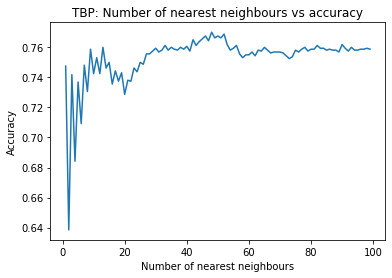

In [37]:
print("Number of neighbours with the highest accuracy:", best_n)
print("Highest accuracy achieved:", best_accuracy)
plt.plot(n_list, test_accuracy)
plt.title("TBP: Number of nearest neighbours vs accuracy")
plt.xlabel("Number of nearest neighbours")
plt.ylabel("Accuracy")

### Implement a Logistic Regression classifier

In [28]:
from sklearn.linear_model import LogisticRegression

In [30]:
t_start2 = time.time()

X = df_shuffled.iloc[:,:-1]
y = df_shuffled.iloc[:,-1]


n_list = [i for i in range(1, 100)]
print(n)
test_accuracy = []

k = 5
kf = KFold(n_splits=k)
classifier = LogisticRegression(random_state=0, solver='liblinear')

acc_score = []
for train_index, test_index in kf.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit the model
    classifier.fit(X_train, y_train)
    pred_values = classifier.predict(X_test)

    accuracy = accuracy_score(pred_values, y_test)
    acc_score.append(accuracy)

avg_acc_score = sum(acc_score) / k
test_accuracy.append(avg_acc_score)

#print("Accuracy: each fold:", acc_score)
print("Average accuracy:", avg_acc_score)
t_end2 = time.time()
t_total2 = t_end2 - t_start2
print("Running time (s):", t_total2)

99
Average accuracy: 0.780058777429467
Running time (s): 0.3510322570800781


#### Perform grid search to find the best model

In [70]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipe = Pipeline([('classifier', LogisticRegression())])
param_grid = [
    {'classifier': [LogisticRegression()],
     'classifier__penalty' : ['l1', 'l2'],  # L1 and L2 regularizations
     'classifier__C': np.logspace(-4, 4, 20), # Strengths of regularization
     'classifier__solver': ['liblinear']
    }
]

# Create a grid search object
clf = GridSearchCV(pipe, param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
best_classifier = clf.fit(X_train, y_train)
print(best_classifier)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.1min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('classifier',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=100,
                                                           multi_class='warn',
                                                           n_jobs=None,
                                                           penalty='l2',
                                                           random_state=None,
                          